In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [7]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.42MB/s]


In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [11]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [13]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
}

In [14]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7bec67647b10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7bec66be8a50>}

In [15]:
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}")

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")


In [17]:
for epoch in range(1, 11):
    train(epoch)
    test()

<ipython-input-15-7bc52cd5143d>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303431
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.848088
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.694854
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.613943
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.681165
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.698466
Test set: Average loss: 0.0161, Accuracy: 8509/10000 (85%
)
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.652748
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.693208
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.646600
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.713583
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.626772
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.583148
Test set: Average loss: 0.0152, Accuracy: 9452/10000 (95%
)
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.589575
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.575099
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.574300
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.537104
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.542554
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.56

In [18]:
device

device(type='cpu')

Prediction: 1


<ipython-input-15-7bc52cd5143d>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


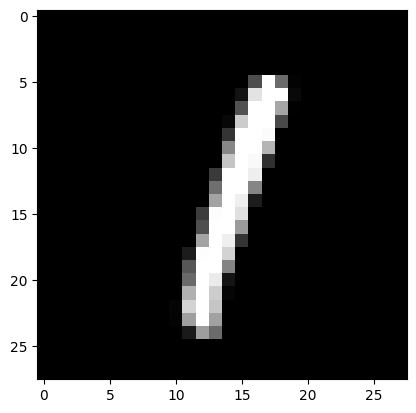

In [25]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[5]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim =1, keepdim=True).item()

print(f"Prediction: {prediction}")
image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()